# **Deep Q-Learning with CartPole 🛒**

*Notebook riadattato dagli esempi disponibili in [GitHub](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/Chapter06/02_dqn_pong.py)*

In this lab, we're going to train a Deep Q-Learning Learning agent to play ***CartPole***.

### 👀 Game overview

Our task consists in learning to balance a pole positioned on a horizontally moving cart that our agent controls.

<img src="https://www.gymlibrary.dev/_images/cart_pole.gif" alt="CartPole"/>

###🎮 Environment:

- [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

###📚 Libraries:

- Python and NumPy
- PyTorch
- [Gymnasium](https://gymnasium.farama.org/) -> library with sample envoronments to practice with Reinforcement Learning (originally by OpenAI)

## The CartPole Environment

The environment docs are available here -> https://gymnasium.farama.org/environments/classic_control/cart_pole/

The CartPole environment is a 2D physical simulator which models the task of balancing a pole on a moving cart, which is controlled by the actions.

Observations consist of 4 real values specifying `[position of cart, velocity of cart, angle of pole, rotation rate of pole]`. The action space is discrete and consists of 2 actions. One applies a force to the cart in the left direction and one applies a force to the right.
For each step where the pole is succesfully balanced and the cart does not go too far from the center, the environment gives a reward of 1. Otherwise the simulation is terminated.

## Dependencies for Visualization

Installs dependencies for visualization of video results.

In [1]:
#environment:
!pip install gymnasium
#!pip install pygame

#progress bar:
!pip install tqdm

#for video:
!pip install imageio
!pip install imageio_ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.3 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import gymnasium as gym
import time, collections
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
import imageio   #for video
from IPython.display import Video   #for video
from google.colab import files   #for video

## DQN Architecture

We implement our DQN as an MLP since the CartPole environment produces 1-dimensional vectors as observations. For environments producing image observations CNN architectures are commonly used.

In [3]:
class DQN(nn.Module):
  def __init__(self, input_features, n_actions, features=24):
    super(DQN, self).__init__()

    # Uses a MLP as backbone
    self.mlp = nn.Sequential(
      nn.Linear(input_features, features),
      nn.ReLU(),
      nn.Linear(features, features * 2),
      nn.ReLU(),
      nn.Linear(features * 2, features * 4),
      nn.ReLU(),
      nn.Linear(features * 4, features * 2),
      nn.ReLU(),
      nn.Linear(features * 2, features),
      nn.ReLU(),
      nn.Linear(features, n_actions)
    )

  def forward(self, x):
    return self.mlp(x)

## Experience Replay Buffer

We then implement our experience replay buffer as a *deque*.

A *deque*, also known as a double-ended queue, is an ordered collection of items similar to the queue. It has two ends, a front and a rear, and the items remain positioned in the collection. What makes a deque different is the unrestrictive nature of adding and removing items. New items can be added at either the front or the rear. Likewise, existing items can be removed from either end.

<img src="https://runestone.academy/ns/books/published/pythonds/_images/basicdeque.png" alt="Deque"/>


We implement sampling operation that selects experience transitions with uniform probability.

In [4]:
# Creates a subclass of Tuple with named attributes representing experience
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceBuffer:
  def __init__(self, capacity):
    # Represents the buffer as a deque
    self.buffer = collections.deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    # Adds the current experience to the buffer
    self.buffer.append(experience)

  def sample(self, batch_size):
    # Samples an index for each element in the batch
    indices = np.random.choice(len(self.buffer), batch_size, replace=False)

    # Extracts experience entries for each element in the batch
    # Each value returned by zip is a list of length batch_size
    states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])

    # Returns results as numpy arrays
    return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), np.array(dones, dtype=np.uint8), np.array(next_states)

## Agent

For convenience, we create an Agent class which manages interaction with the environment and populates the experience buffer. When new experience is requested, the agent uses the network to sample the action with highest Q-value and performs a step in the environment following that action. The resulting transition is stored in the replay buffer.

A common practice is to sample with probability $\epsilon$ a random action instead of the one with highest Q-value. This helps the agent in increasing the exploration of the environment. $\epsilon$ starts from 1 and is linearly annealed during training.

In [5]:
class Agent:
  def __init__(self, env, exp_buffer):
    self.env = env
    self.exp_buffer = exp_buffer
    self._reset()

  def _reset(self):
    # Restarts the environment and resets the accumulated reward
    state, _ = self.env.reset()
    self.state = state.astype(np.float32)
    self.total_reward = 0.0

  def play_step(self, net, epsilon=0.0, device="cpu", video=False):

    # No need to create a computational graph when gathering experience
    with torch.no_grad():
      # Will contain the total reward for the episode if the episode ends
      # or None otherwise
      done_reward = None

      # Sample the action randomly with probability epsilon
      if np.random.random() < epsilon:
        action = self.env.action_space.sample()
      # Otherwise select action based on qvalues
      else:
        # Creates a batch made of a single state
        #state_a = np.array([self.state], copy=False)
        state_tensor = torch.tensor(self.state).unsqueeze(0).to(device)

        # Gets qvalues and select the index of the maximum
        q_values = net(state_tensor)
        _, selected_action = torch.max(q_values, dim=1)
        action = int(selected_action.item())

      # Perform a step in the environment
      new_state, reward, is_done, _, _ = self.env.step(action)
      new_state = new_state.astype(np.float32)
      self.total_reward += reward

      # Saves the new experience
      exp = Experience(self.state, action, reward, is_done, new_state)
      self.exp_buffer.append(exp)

      # Registers the current state
      self.state = new_state

      # If the episode is finished, reset the environment
      if is_done:
        done_reward = self.total_reward
        self._reset()

      if video == True:
        # Gets the current representation of the environment
        current_rgb_image = self.env.render()
        return done_reward, current_rgb_image
      else:
        return done_reward

## Loss Function

We define a helper function that implements the loss function $L$ for a minibatch of elements sampled from the experience buffer using the actor and target networks to compute Q-values.

In [6]:
def calc_loss(batch, net, target_net, device="cpu"):

  # Unpacks the batch
  states, actions, rewards, dones, next_states = batch

  #states_v = torch.tensor(np.array(states, copy=False)).to(device)
  #next_states_v = torch.tensor(np.array(next_states, copy=False)).to(device)

  # Transforms the batch elements to tensors
  states_v = torch.from_numpy(states).to(device)
  next_states_v = torch.from_numpy(next_states).to(device)
  actions_v = torch.tensor(actions).to(device)
  rewards_v = torch.tensor(rewards).to(device)
  done_mask = torch.BoolTensor(dones).to(device)

  # Infers the qvalues for the states
  state_qvalues = net(states_v)
  # Extracts the qvalues for the action that was selected
  state_action_qvalues = state_qvalues.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

  with torch.no_grad():
    # Computes the qvalues for the next states using the target DQN
    next_state_qvalues = target_net(next_states_v)
    # Extracts the maximum one
    next_state_max_qvalue = next_state_qvalues.max(dim=1)[0]
    # If the next state refers to an ended episode, it has no value
    next_state_max_qvalue[done_mask] = 0.0
    next_state_max_qvalue = next_state_max_qvalue.detach()

  # Computes the expected qvalue using the Bellman equation
  expected_state_action_qvalues = rewards_v + GAMMA * next_state_max_qvalue

  # Penalizes the DQN for inferring a qvalue different from the one
  # computed with the target DQN using the Bellman equation
  return nn.MSELoss()(state_action_qvalues, expected_state_action_qvalues)

## Train Loop

We then put everything together to train our network

In [7]:
DEFAULT_ENV_NAME = "CartPole-v1"
# We terminate training if the model on average balances the pole for at least N steps
MEAN_REWARD_BOUND = 100

# Discount factor
GAMMA = 0.99
BATCH_SIZE = 32
# Size of the replay buffer
REPLAY_SIZE = 10000
# Warmup frames for the replay buffer
REPLAY_START_SIZE = 10000
LEARNING_RATE = 1e-4
# Number of steps at which transfer weights from the DQN to the target DQN
SYNC_TARGET_FRAMES = 1000

EPSILON_DECAY_LAST_FRAME = 15000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

writer = {"epsilon": [], "speed": [], "reward_100": [], "reward": []}

In [8]:
def train(net, target_net, env, buffer, agent, device, writer):

  # Epsilon starts from the initial value and is then annealed
  epsilon = EPSILON_START

  # Instantiates the optimizer. Note that target_net is not optimized
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  total_rewards = []
  frame_idx = 0

  # Frame idx and time at which the last episode ended
  ts_frame = 0
  ts = time.time()
  best_m_reward = None
  print(f"Training started!\n")

  while True:
    frame_idx += 1

    # Computes the current epsilon with linear annealing
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    # Performs a step in the environment to gather experience
    # reward, rbg_image = agent.play_step(net, epsilon, device=device)
    reward = agent.play_step(net, epsilon, device=device)

    # If the current episode has ended
    if reward is not None:
      # Registers the current total reward
      total_rewards.append(reward)

      # Computes training speed
      speed = (frame_idx - ts_frame) / (time.time() - ts)
      ts_frame = frame_idx
      ts = time.time()

      # Computes the mean reward over the last 100 episodes
      m_reward = np.mean(total_rewards[-100:])

      # Logs values
      writer["epsilon"].append(epsilon)
      writer["speed"].append(speed)
      writer["reward_100"].append(m_reward)
      writer["reward"].append(reward)

      # Updates best rewards
      if best_m_reward is None or best_m_reward < m_reward:
        best_m_reward = m_reward
        # # Save model:
        # torch.save(net.state_dict(), f"{args.env}-best_{m_reward:.0f}.dat")
        # if best_m_reward is not None:
        #     print(f"\nBest reward updated {best_m_reward:.3f} -> {m_reward:3f}")


      # Stops training when a certain reward is achieved
      if m_reward > MEAN_REWARD_BOUND:
        print(f"SOLVED in {frame_idx} frames!")
        print(f"Final game reward: {m_reward:.2f}, best reward {best_m_reward:.2f}, eps: {epsilon:.2f}")
        break

      # Update print:
      if frame_idx % 100 == 0:
        print(f"Frame {frame_idx}: done {len(total_rewards)} games, reward: {m_reward:.2f}, best reward {best_m_reward:.2f}, eps: {epsilon:.2f}")

    # Continue to collect experience until the warmup finishes
    if len(buffer) < REPLAY_START_SIZE:
      continue

    # At regular intervals load the weights of the DQN into the target DQN
    if frame_idx % SYNC_TARGET_FRAMES == 0:
      target_net.load_state_dict(net.state_dict())

    # Perform an optimization step
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, target_net, device=device)
    loss_t.backward()
    optimizer.step()
  return writer

## Train

In [9]:
device = torch.device("cuda:0")

# Makes the environment
env = gym.make(DEFAULT_ENV_NAME, render_mode="rgb_array")

# Creates the DQN and target DQN models
net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
print(net)

# Instantiates the experience buffer and the agent that collects experience
buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=96, bias=True)
    (5): ReLU()
    (6): Linear(in_features=96, out_features=48, bias=True)
    (7): ReLU()
    (8): Linear(in_features=48, out_features=24, bias=True)
    (9): ReLU()
    (10): Linear(in_features=24, out_features=2, bias=True)
  )
)


In [10]:
# Trains the network
writer = train(net, target_net, env, buffer, agent, device, writer)

Training started!

Frame 1200: done 52 games, reward: 23.08, best reward 27.56, eps: 0.92
Frame 2800: done 132 games, reward: 20.89, best reward 27.56, eps: 0.81
Frame 3900: done 186 games, reward: 19.22, best reward 27.56, eps: 0.74
Frame 6100: done 316 games, reward: 16.45, best reward 27.56, eps: 0.59
Frame 7900: done 442 games, reward: 14.29, best reward 27.56, eps: 0.47
Frame 9400: done 557 games, reward: 12.87, best reward 27.56, eps: 0.37
Frame 9700: done 581 games, reward: 12.82, best reward 27.56, eps: 0.35
Frame 9900: done 597 games, reward: 12.80, best reward 27.56, eps: 0.34
Frame 12100: done 770 games, reward: 13.16, best reward 27.56, eps: 0.19
Frame 13700: done 907 games, reward: 11.75, best reward 27.56, eps: 0.09
Frame 14100: done 935 games, reward: 12.34, best reward 27.56, eps: 0.06
Frame 14500: done 954 games, reward: 14.01, best reward 27.56, eps: 0.03
Frame 15100: done 978 games, reward: 17.26, best reward 27.56, eps: 0.01
SOLVED in 25511 frames!
Final game reward

# Results

Plot training results:

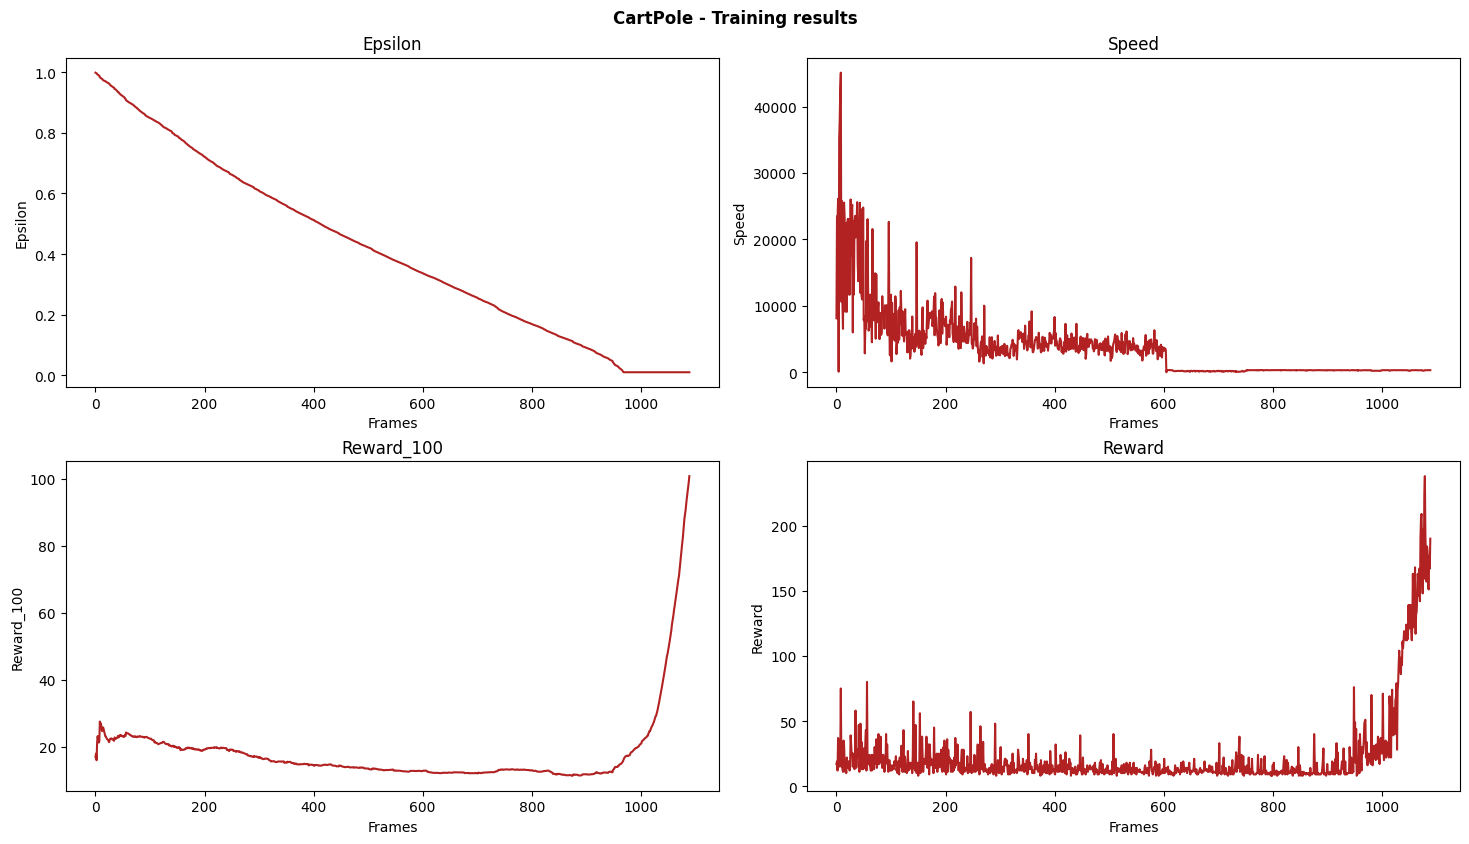

In [11]:
fig, subs = plt.subplots(2, 2, figsize=(700*2/96, 400*2/96), constrained_layout=True)
fig.suptitle(f"CartPole - Training results", fontsize=12, fontweight='bold')
c = 0

for i in range(2):
  for j in range(2):
    sub1 = subs[i][j]
    k = list(writer.keys())[c]
    sub1.set_title(k.title())
    sub1.plot(writer[k], color="firebrick", linewidth=1.5)
    sub1.set_xlabel(f"Frames")
    sub1.set_ylabel(k.title())
    c += 1

plt.show()

Get sample video:

In [34]:
# For visualization purposes, we create a helper function that uses the DQN to play an episode in the environment:
def save_episode(net, env, agent, device, video_path, fps=10):
  # Resets the environment
  agent._reset()
  all_frames = []
  reward = None

  # Plays an episode
  while reward is None:
    reward, rgb_image = agent.play_step(net, epsilon=0.0, device=device, video=True)
    all_frames.append(rgb_image)

  # Saves the video
  imageio.mimsave(video_path, all_frames, fps=fps)

In [35]:
# Saves a sample episode
video_path = "cartpole_final.mp4"
save_episode(net, env, agent, device, video_path)

Play the video:

In [36]:
Video(video_path, embed=True)

Download video:

In [37]:
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Theoretical comment on the implementation

[DQNs](https://arxiv.org/abs/1312.5602) are powerful models which became a milestone in RL. The main idea of DQNs is to use neural networks as estimators for the Q-value function of a state and to train it following the Bellman equation for Q-values. More precisely, the Bellman equation defines the value function $V$

$V(s) = r(s) + \gamma \max_a \sum_{s'} P(s'|s,a)V(s')$

The same equation can be expressed in Q-value form avoiding the maximization over $a$

$Q(s,a) = \\ = r(s) + \gamma \sum_{s'} P(s'|s,a)V(s') =\\= r(s) + \gamma \sum_{s'} P(s'|s,a)\max_{a'} Q(s',a')$

since

$V(s) = \max_a Q(s,a)$

This equation can be seen as an expectation over the probability distribution $P(s'|s,a)$ of the reward plus the discounted value of the next state

$Q(s,a) = \mathbb{E}_{s' \sim P(s'|s,a)} [r(s) + \gamma \max_{a'} Q(s',a')]$

### Training

For training, we assume two networks estimating Q-values are available: $Q_{actor}$ and $Q_{target}$.

First, we initialize our environment and we create an *Experience Replay Buffer* which will hold a number of state transitions sampled from the environment in the form of tuples $(s, a, r, s', done)$. At each training step, we use the actor network $Q_{actor}$ to sample an action and gather a new transition to insert into the experience replay buffer. We then proceed to update the network weights. We call

$y(s,a) = r(s) + \gamma \max_{a'} Q_{target}(s',a')$

Note how we replaced the expectation in the $Q(s,a)$ equation with a sampling operation to get an estimate $y(s,a)$ for the Q-value $Q(s,a)$ from the target network. We perform sampling using our experience replay buffer.

Intuitively, we would like $Q_{actor}$ to predict Q-values that are consistent with the predictions of $Q_{target}$ so we pose

$L = [y(s,a) - Q_{actor}(s,a)]^2$

and optimize the loss with respect to the weights of $Q_{actor}$. Note how the sampled rewards $r(s)$ contribute to improve the precision of the estimate for $Q(s,a)$ by integrating knowledge sampled from the environment. $Q_{actor}$ progressively produces better Q-value estimates, so at regular intervals we copy the weights of $Q_{actor}$ to $Q_{target}$. Copying is not performed at every training step because frequent updates to $Q_{target}$ would cause abrupt changes in the training objective, leading to training instability.